# Libreries

In [1]:
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import pandas as pd
from keras import layers


from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, DenseNet121, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

2025-03-25 13:51:11.156738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 13:51:11.225751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742921471.250754    4780 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742921471.260518    4780 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 13:51:11.323943: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Definitions

In [2]:
pwd

'/home/nicolas/Documentos/UTN/INA/giar_ina_dev/notebooks/train'

In [7]:

train_path = "../../output/dataset_test/AutoEncoder_agglomerative_v2/train/"
validation_path = "../../output/dataset_test/AutoEncoder_agglomerative_v2/validation"
test_path = "../../output/dataset_test/test_roboflow/"

# train_path = "../../output/cropped_cells_onion/media/train"
# validation_path = "../../output/cropped_cells_onion/media/valid"
# test_path = "../../output/cropped_cells_onion/media/test/"

encoder_path = "../../models/encoder_SSIM_MAE_Bparams.keras"
save_path="../../output/results"



In [8]:
SHAPE = (128,128,1)
batch_size = 48
TRAIN_ENCODER = False
COLOR_MODE="grayscale"

# Confusion matrix

In [9]:

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [10]:
results = []
def plot_conf_matrix(model, generator, titulo='Confusion matrix'):
    ### RETRIVE TEST LABEL FROM GENERATOR ###
    test_num = sum(1 for _ in generator)
    label_test = []
    pred_test = []

    for i, batch in enumerate(generator):
        X, y = batch
        label_test.append(y.numpy())
        predictions = model.predict(X)
        pred_test.append(predictions)

    label_test = np.argmax(np.vstack(label_test), axis=1)


    ### COMPUTE PREDICTIONS ON TEST DATA ###
    pred_test = np.argmax(np.vstack(pred_test), axis=1)
    accuracy=accuracy_score(label_test, pred_test)
    recall=recall_score(label_test, pred_test,pos_label=0)
    specificity=recall_score(label_test, pred_test,pos_label=1)
    precision = precision_score(label_test, pred_test, pos_label=0)
    # pred_test = pred_test[:label_test.shape[0],]
    ### ACCURACY ON TEST DATA ###
    print("-" * 40)
    print('ACCURACY:', accuracy)
    print('RECALL:',recall)
    print('PRECISION:', precision)
    print('SPECIFICITY:',specificity)
    print("-" * 40)
    print("\n")
    ### CONFUSION MATRIX ON TEST DATA ###
    cnf_matrix = confusion_matrix(label_test, pred_test)
    results.append({'Model': titulo, 'Accuracy': accuracy , 'Recall':recall,'Precision':precision,'Specificity':specificity})

    plt.figure(figsize=(7,7))
    plot_confusion_matrix(cnf_matrix, classes=['cell', 'not'], title=titulo)
    plt.title(titulo)
    plt.show()


# Datasets

In [11]:
# data generator function
def data_gen ():
    train_generator = tf.keras.utils.image_dataset_from_directory(
        train_path,
        labels="inferred",
        label_mode="categorical",
        batch_size=batch_size,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    train_generator = train_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_generator = train_generator.prefetch(buffer_size=tf.data.AUTOTUNE)


    validation_generator = tf.keras.utils.image_dataset_from_directory(
        validation_path,
        labels="inferred",
        label_mode="categorical",
        batch_size=batch_size,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    validation_generator = validation_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    validation_generator = validation_generator.prefetch(buffer_size=tf.data.AUTOTUNE)



    test_generator = tf.keras.utils.image_dataset_from_directory(
        test_path,
        labels="inferred",
        label_mode="categorical",
        batch_size=batch_size,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    test_generator = test_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    test_generator = test_generator.prefetch(buffer_size=tf.data.AUTOTUNE)


    return train_generator,validation_generator,test_generator


Found 7000 files belonging to 2 classes.
(48, 128, 128, 1)
(48, 2)


I0000 00:00:1742921496.347340    4780 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20905 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


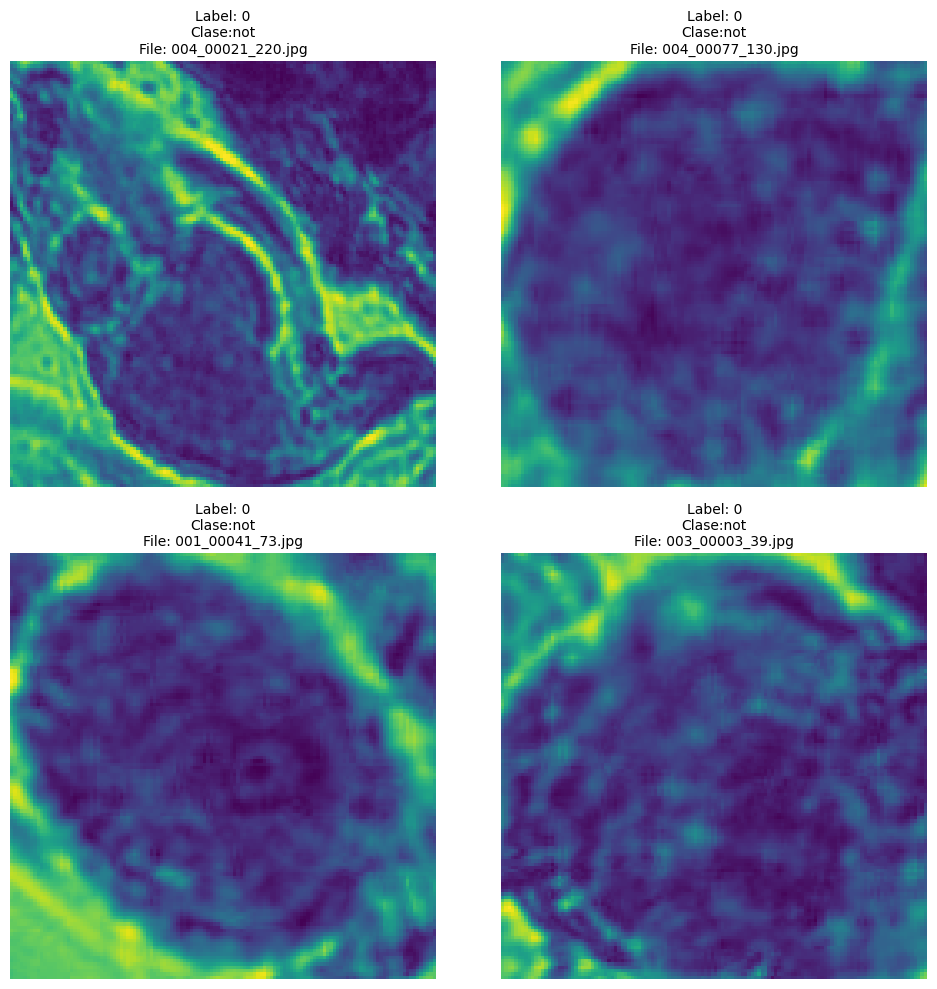

In [12]:
# plot images

file_paths = []
labels = []

for label_dir in os.listdir(train_path):
    label_dir_path = os.path.join(train_path, label_dir)
    if os.path.isdir(label_dir_path):
        for image_name in os.listdir(label_dir_path):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                file_paths.append(os.path.join(label_dir_path, image_name))
                labels.append(label_dir)
train_generator = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(SHAPE[0], SHAPE[1]),
    color_mode=COLOR_MODE,
    shuffle=False,
)



for images, labels in train_generator:
    print(images.shape)
    print(labels.shape)

    #filenames_in_batch = [train_generator.filenames[idx] for idx in train_generator.index_array]

    plt.figure(figsize=(10, 10))

    for i in range(4):
        directory, file_name = os.path.split(file_paths[i])
        folder_name = os.path.basename(directory)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))

        #file_name = filenames_in_batch[i]
        label = np.argmax(labels[i])
        plt.title(f"Label: {label}\nClase:{folder_name}\nFile: {file_name}", fontsize=10)

        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

# Model

In [13]:

def get_model(pretrain_encoder,TRAIN_ENCODER,input_shape):

    encoder=pretrain_encoder

    inp = keras.Input(shape=input_shape)
    x = inp

    encoder.trainable = TRAIN_ENCODER

    x = encoder(x)

    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    out =layers.Dense(2, activation='linear')(x)


    model = keras.Model(inp, out)

    return model


# Train

Found 7000 files belonging to 2 classes.
Found 6676 files belonging to 2 classes.
Found 623 files belonging to 2 classes.
Epoch 1/150


I0000 00:00:1742921511.805552    7574 service.cc:148] XLA service 0x7aa3d0006950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742921511.805795    7574 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-25 13:51:51.847358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742921511.977210    7574 cuda_dnn.cc:529] Loaded cuDNN version 90701


 92/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5072 - loss: 1.2644

I0000 00:00:1742921513.101745    7574 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5101 - loss: 1.2564 - val_accuracy: 0.6983 - val_loss: 1.0017
Epoch 2/150
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5145 - loss: 1.1551 - val_accuracy: 0.6691 - val_loss: 0.9896
Epoch 3/150
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5262 - loss: 1.1088 - val_accuracy: 0.6493 - val_loss: 0.9766
Epoch 4/150
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5331 - loss: 1.0618 - val_accuracy: 0.6507 - val_loss: 0.9604
Epoch 5/150
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5682 - loss: 1.0171 - val_accuracy: 0.6860 - val_loss: 0.9428
Epoch 6/150
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5675 - loss: 0.9821 - val_accuracy: 0.7448 - val_loss: 0.9222
Epoch 7/150
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5760 - loss: 0.9759 - val_accuracy: 0.8165 - val_loss: 0.9026
Epoch 8/150
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6065 - loss: 0.9399 - val_accuracy: 0.878

<Axes: >

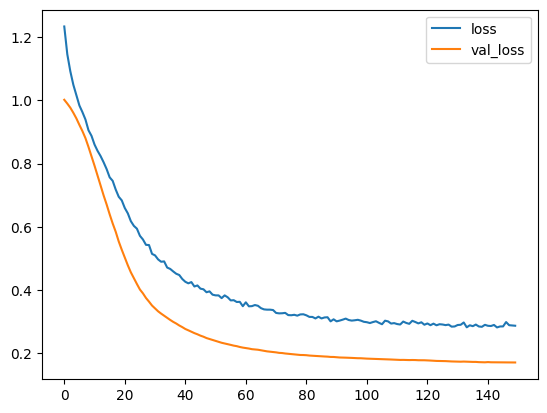

In [14]:
encoder_name="Encoder_SSIM+MAE"
encoder= keras.saving.load_model(encoder_path)
model = get_model(encoder,TRAIN_ENCODER,SHAPE)

train_generator,validation_generator,test_generator=data_gen()

stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2,
)


model.compile(
    keras.optimizers.Adam(learning_rate= 0.0001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(train_generator,
          epochs=150,
          validation_data = validation_generator,
          callbacks=[ stopping],
)

metrics = pd.DataFrame(history.history)
metrics[['loss', 'val_loss']].plot()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━

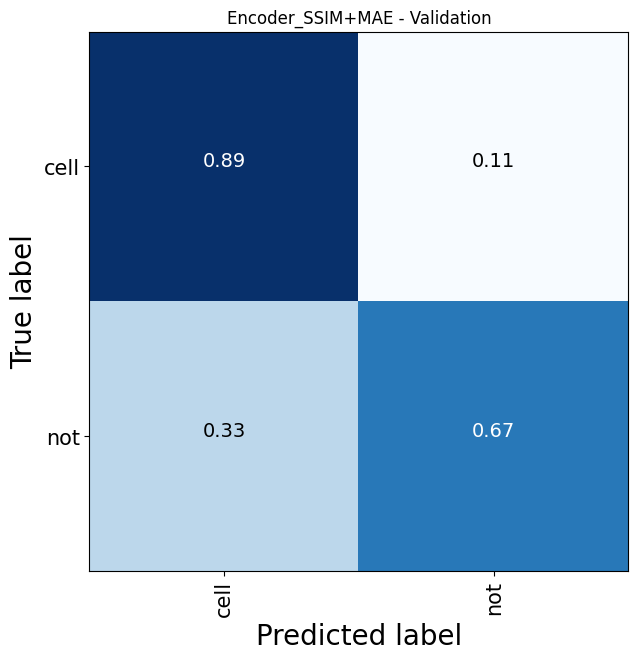

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
----------------------------------------
ACCURACY: 0.7030497592295345
RECALL: 0.6805111821086262
PRECISION: 0.714765100671141
SPECIFICITY: 0.7258064516129032
----------------------------------------




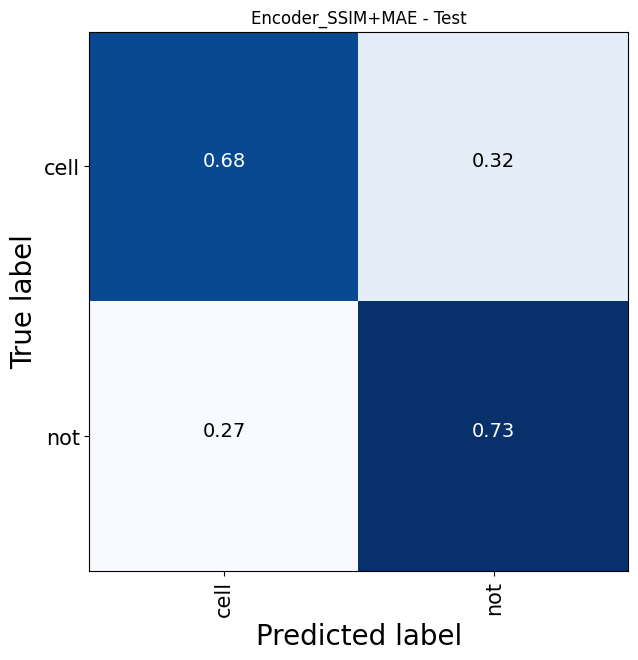

In [18]:
model = keras.models.load_model('/home/nicolas/Descargas/model_Encoder_SSIM+MAE.keras')
plot_conf_matrix(model, validation_generator, f'{encoder_name} - Validation')
plot_conf_matrix(model, test_generator, f'{encoder_name} - Test')

In [ ]:
model.save(save_path+f'/model_{encoder_name}.keras')

<Axes: >

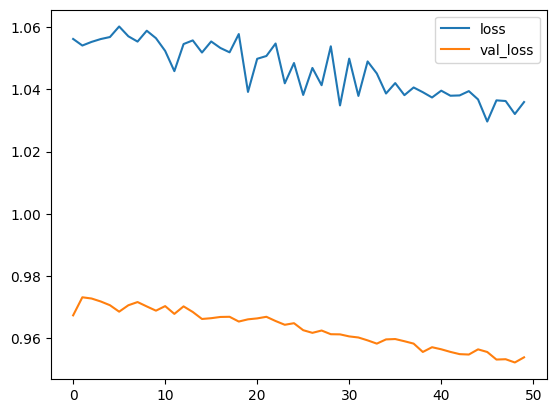

In [12]:
import pandas as pd

results_df = pd.DataFrame(results)

results_df.to_excel(save_path+"/resultados_Encoder_SSIM+MAE.xlsx")

print(results_df)


                           Model  Accuracy    Recall  Precision  Specificity
0  Encoder_SSIM+MAE - Validation  0.981332  0.992262   0.965925     0.972857
1        Encoder_SSIM+MAE - Test  0.740500  0.558000   0.878740     0.923000
